In [1]:
import pyprob
from pyprob import Model
from pyprob import InferenceEngine
from pyprob.distributions import Normal
from pyprob.dis import ModelDIS

import torch
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure();

<Figure size 432x288 with 0 Axes>

# Defining the Model

In [2]:
class GaussianUnknownMean(Model):
    def __init__(self):
        super().__init__(name='Gaussian with unknown mean') # give the model a name
        self.prior_mean = 1
        self.prior_std = math.sqrt(5)
        self.likelihood_std = math.sqrt(2)

    def forward(self): # Needed to specifcy how the generative model is run forward
        # sample the (latent) mean variable to be inferred:
        mu = pyprob.sample(Normal(self.prior_mean, self.prior_std)) # NOTE: sample -> denotes latent variables

        # define the likelihood
        likelihood = Normal(mu, self.likelihood_std)

        # Lets add two observed variables
        # -> the 'name' argument is used later to assignment values:
        #pyprob.observe(likelihood, name='obs0') # NOTE: observe -> denotes observable variables

        # return the latent quantity of interest
        return mu
    
class GaussianDIS(GaussianUnknownMean, ModelDIS):
    def __init__(self):
        super().__init__()
        self.obs = 8
        #self.bool_func = bool_func
    def dummy_bernoulli(self, x):
        return True
    def forward(self):
        x = super().forward()
        euclidean_dist = np.abs(x - self.obs)
        delta_val = self.dummy_bernoulli(x)
        bool_func_dist = pyprob.distributions.Bernoulli(delta_val)
        pyprob.observe(bool_func_dist, name = "bool_func")
        dummy = pyprob.distributions.Normal(euclidean_dist,0.1)
        pyprob.observe(dummy, euclidean_dist, name = "distance") # Any other way to do this?
        return x

model = GaussianUnknownMean()
simulator = GaussianDIS()

# Finding the correct posterior analytically
Since all distributions are gaussians in this model, we can analytically compute the posterior and we can compare the true posterior to the inferenced one.

Assuming that the prior and likelihood are $p(x) = \mathcal{N}(\mu_0, \sigma_0)$ and $p(y|x) = \mathcal{N}(x, \sigma)$ respectively and, $y_1, y_2, \ldots y_n$ are the observed values, the posterior would be $p(x|y) = \mathcal{N}(\mu_p, \sigma_p)$ where,
$$
\begin{align}
\sigma_{p}^{2} & = \frac{1}{\frac{n}{\sigma^2} + \frac{1}{\sigma_{0}^{2}}} \\
\mu_p & = \sigma_{p}^{2} \left( \frac{\mu_0}{\sigma_{0}^{2}} + \frac{n\overline{y}}{\sigma^2} \right)
\end{align}
$$
The following class implements computing this posterior distribution. We also implement some helper functions and variables for plotting the correct posterior and prior.

In [3]:
def plot_function(min_val, max_val, func, *args, **kwargs):
        x = np.linspace(min_val,max_val,int((max_val-min_val)*50))
        plt.plot(x, np.vectorize(func)(x), *args, **kwargs)

def get_dist_pdf(dist):
    return lambda x: math.exp(dist.log_prob(x))
        
class CorrectDistributions:
    def __init__(self, model):
        self.prior_mean = model.prior_mean
        self.prior_std = model.prior_std
        self.likelihood_std = model.likelihood_std
        self.prior_dist = Normal(self.prior_mean, self.prior_std)
        
    @property
    def observed_list(self):
        return self.__observed_list

    @observed_list.setter
    def observed_list(self, new_observed_list):
        self.__observed_list = new_observed_list
        self.construct_correct_posterior()
    
    def construct_correct_posterior(self):
        n = len(self.observed_list)
        posterior_var = 1/(n/self.likelihood_std**2 + 1/self.prior_std**2)
        posterior_mu = posterior_var * (self.prior_mean/self.prior_std**2 + n*np.mean(self.observed_list)/self.likelihood_std**2)
        self.posterior_dist = Normal(posterior_mu, math.sqrt(posterior_var))

    def prior_pdf(self, model, x):
        p = Normal(model.prior_mean,model.prior_stdd)
        return math.exp(p.log_prob(x))

    def plot_posterior(self, min_val, max_val):
        if not hasattr(self, 'posterior_dist'):
            raise AttributeError('observed values are not set yet, and posterior is not defined.')
        plot_function(min_val, max_val, get_dist_pdf(self.posterior_dist), label='correct posterior', color='orange')


    def plot_prior(self, min_val, max_val):
        plot_function(min_val, max_val, get_dist_pdf(self.prior_dist), label='prior', color='green')


In [4]:
correct_dists = CorrectDistributions(model)
correct_dists.observed_list=[8]

# Training

For a sanity check, start with one training round.

In [5]:
simulator.train(iterations = 1,
    importance_sample_size=5000, 
    proposal_mixture_components=5,
    observe_embeddings={'bool_func': {'dim': 1, 'depth': 1}} # Dummy value as we currently have to observe something
)

Creating new inference network...
Observable bool_func: reshape not specified, using shape torch.Size([]).
Observable bool_func: using embedding dim torch.Size([1]).
Observable bool_func: observe embedding not specified, using the default FEEDFORWARD.
Observable bool_func: using embedding depth 1.
Observe embedding dimension: 1
Train. time | Epoch| Trace     | Init. loss| Min. loss | Curr. loss| T.since min | Learn.rate| Traces/sec
New layers, address: 16__forward__mu__Normal__1, distribution: Normal
Total addresses: 1, parameters: 157
0d:00:00:00 | 1    | 400       | +2.29e+00 | +2.23e+00 | +2.26e+00 | 0d:00:00:00 | +1.00e-03 | 1,227.0                               
Stop condition reached. num_traces: 500
0d:00:00:00 | 1    | 500       | +2.29e+00 | +2.23e+00 | +2.25e+00 | 0d:00:00:00 | +1.00e-03 | 1,185.2                               
Time spent  | Time remain.| Progress             | Trace     | ESS    | Traces/sec
0d:00:00:09 | 0d:00:00:00 | #################### | 5000/5000 | 4764

In [6]:
prior = simulator.prior_results(num_traces = 2000)
posterior_check = simulator.posterior(num_traces = 2000,
inference_engine = InferenceEngine.IMPORTANCE_SAMPLING_WITH_INFERENCE_NETWORK,
observe={"bool_func": 1})
posterior_check = simulator.update_DIS_posterior_weights(posterior_check)
results_check = np.array([x.result for x in posterior_check.values])

Time spent  | Time remain.| Progress             | Trace     | ESS    | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 2000/2000 | 2000.00 | 1,811.42       
Time spent  | Time remain.| Progress             | Trace     | ESS    | Traces/sec
0d:00:00:03 | 0d:00:00:00 | #################### | 2000/2000 | 1891.77 | 547.45       


Now do 50 more iterations.

In [7]:
simulator.train(iterations = 50,
    importance_sample_size=5000, 
    proposal_mixture_components=5,
    observe_embeddings={'bool_func': {'dim': 1, 'depth': 1}} # Dummy value as we currently have to observe something
)

Time spent  | Time remain.| Progress             | Trace     | ESS    | Traces/sec
0d:00:00:08 | 0d:00:00:00 | #################### | 5000/5000 | 4737.31 | 568.84       
OfflineDataset at: .
Num. traces      : 500
Sorted on disk   : False
No pre-computed hashes found, generating: ./pyprob_hashes
Hashing offline dataset for sorting
Time spent  | Time remain.| Progress             | Traces  | Traces/sec
0d:00:00:00 | 0d:00:00:00 | #################### | 500/500 | 1,544.42       
Sorting offline dataset
Sorting done
Num. trace types : 1
Trace hash	Count
1.65120542	500

Continuing to train existing inference network...
Total number of parameters: 157
Train. time | Epoch| Trace     | Init. loss| Min. loss | Curr. loss| T.since min | Learn.rate| Traces/sec
0d:00:00:01 | 1    | 1,100     | +2.29e+00 | +2.23e+00 | +3.56e+00 | 0d:00:00:00 | +1.00e-03 | 1,604.1 
Stop condition reached. num_traces: 500
0d:00:00:01 | 1    | 1,500     | +2.29e+00 | +2.23e+00 | +3.54e+00 | 0d:00:00:00 | +1.00e-03 | 

In [15]:
posterior = simulator.posterior(num_traces = 2000,
inference_engine = InferenceEngine.IMPORTANCE_SAMPLING_WITH_INFERENCE_NETWORK,
observe={"bool_func": 1})
posterior = simulator.update_DIS_posterior_weights(posterior)
results = np.array([x.result for x in posterior.values])

Time spent  | Time remain.| Progress             | Trace     | ESS    | Traces/sec
0d:00:00:03 | 0d:00:00:00 | #################### | 2000/2000 | 773.54 | 521.47       


# Plots

First do checks for single training round. This is to make sure that the algorithm isn't somehow 'cheating'

In [9]:
posterior_check = simulator.update_DIS_posterior_weights(posterior_check)
results_check = np.array([x.result for x in posterior_check.values])

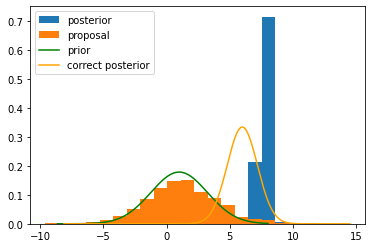

In [10]:
plt.hist(results_check, bins=20, weights=np.array(posterior_check.weights), label='posterior',density=True)
plt.hist(results_check, bins=20, label='proposal',density = True)
correct_dists.plot_prior(min(prior.values_numpy()),max(prior.values_numpy()))
correct_dists.plot_posterior(min(results), max(results))
plt.legend()

Now check full results

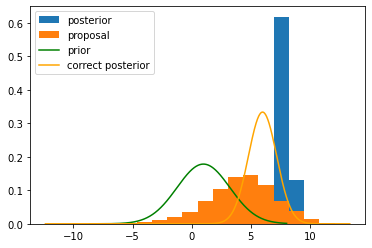

In [16]:
plt.hist(results, bins=20, weights=np.array(posterior.weights), label='posterior',density=True)
plt.hist(results, bins=20, label='proposal',density = True)
correct_dists.plot_prior(min(prior.values_numpy()),max(prior.values_numpy()))
correct_dists.plot_posterior(min(results), max(results))
plt.legend()

# Roughs

In [12]:
importance_weights = np.exp(np.array([x.log_importance_weight for x in posterior.values]))
importance_weights = importance_weights/sum(importance_weights)
weights = posterior.weights
probs = posterior._categorical.probs
print(importance_weights[:10])
print(np.array(weights[:10].detach()))
print(np.array(probs[:10].detach()))

[2.11851106e-03 3.72435386e-04 4.69502051e-04 2.15096266e-05
 6.68200422e-05 1.31136282e-04 5.67968146e-06 1.34540666e-04
 2.65440747e-04 1.03225203e-03]
[2.11851103e-03 3.72435380e-04 4.69502044e-04 2.15096263e-05
 6.68200412e-05 1.31136280e-04 5.67968138e-06 1.34540664e-04
 2.65440743e-04 1.03225214e-03]
[2.11851103e-03 3.72435380e-04 4.69502044e-04 2.15096263e-05
 6.68200412e-05 1.31136280e-04 5.67968138e-06 1.34540664e-04
 2.65440743e-04 1.03225214e-03]


In [13]:
print(importance_weights.sum())
print(weights.sum())

0.9999999999999997
tensor(1.0000, dtype=torch.float64)


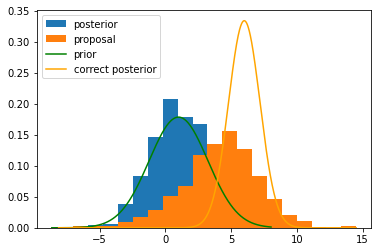

In [14]:
plt.hist(results, bins=20, weights=importance_weights, label='posterior')
plt.hist(results, bins=20, label='proposal',density = True)
correct_dists.plot_prior(min(prior.values_numpy()),max(prior.values_numpy()))
correct_dists.plot_posterior(min(results), max(results))
plt.legend()

Why do importance weights bring the posterior back to the prior?